# Singal To Noise All Models
 - Calculates the singal to nosie for all models in longrunmip for GMST
 - Fraction of models stable for windows for GMST
 
 PHD-9:
 * read_and_merge_netcdfs moved from longrunmip_loader to open_ds


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from importlib import reload
import matplotlib as mpl
import string
import matplotlib.ticker as mticker
import os, sys
import constants
sys.path.append(constants.MODULE_DIR)
import sn_plotting as sn_plot
import xarray_class_accessors as xca
import open_ds
import signal_to_noise as sn
import xarray_extender as xce
import utils
from classes import ExperimentTypes
from itertools import groupby
warnings.filterwarnings('ignore')
logger = utils.get_notebook_logger()

from functools import partial

In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory('dask-worker-space')
dask.distributed.Client(local_directory=tempdir.name, memory_limit='32gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 119.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33997,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 119.21 GiB
Comm: tcp://127.0.0.1:44369,Total threads: 4
Dashboard: http://127.0.0.1:40819/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:35509,


In [201]:
notebook_number='03_00'
experiment_params = constants.EXPERIMENTS_TO_RUN[6] # 0, 1, 2 3, 4, 5, 6, 7
experiment_params

{'variable': 'surf', 'mask': 'sea', 'hemisphere': 'northern_hemisphere'}

In [202]:
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, experiment_params["variable"], 'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/surf/regrid_retimestamped'

In [203]:
units = constants.VARIABLE_INFO[experiment_params["variable"]]["units"]
longname = constants.VARIABLE_INFO[experiment_params["variable"]]['longname']
print(f'{longname=}', f'{units=}', sep=' , ')

longname='Neat Ocean Heat Uptake' , units='W/m^2'


# Loading Data

In [204]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [205]:
files_to_open_experiment = open_ds.get_file_names_from_from_directory(
    ROOT_DIR, ExperimentTypes.ABRUPT4X, models_to_get)

files_to_open_control = open_ds.get_file_names_from_from_directory(
    ROOT_DIR, ExperimentTypes.CONTROL, models_to_get)

utils.pprint_list(files_to_open_experiment, num_start_items=5)

- model='ipslcm5a' - found_fname=None - No file found
- model='ipslcm5a' - found_fname=None - No file found
lenght = 6
 0. surf_ann_CCSM3_abrupt4x_2130_g025.nc
 1. surf_ann_CESM104_abrupt4x_5900_g025.nc
 2. surf_ann_CNRMCM61_abrupt4x_1850_g025.nc
 3. surf_ann_HadCM3L_abrupt4x_1000_g025.nc
 4. surf_ann_MPIESM11_abrupt4x_4520_g025.nc


In [206]:
control_ds = open_ds.read_and_merge_netcdfs(files_to_open_control, ROOT_DIR, 
                                            mask=experiment_params['mask'])
abrupt4x_ds = open_ds.read_and_merge_netcdfs(files_to_open_experiment, ROOT_DIR,
                                             mask=experiment_params['mask'])
abrupt4x_ds

- Removing first 10 steps


<xarray.Dataset>
Dimensions:   (time: 1200, lat: 72, lon: 144)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    depth     float64 0.0
Data variables:
    ccsm3     (time, lat, lon) float32 nan nan nan nan ... -7.763 -7.569 -7.385
    cesm104   (time, lat, lon) float32 nan nan nan nan ... -7.166 -7.354 -7.524
    cnrmcm61  (time, lat, lon) float32 nan nan nan nan ... 1.192 0.982 0.466
    hadcm3l   (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    mpiesm11  (time, lat, lon) float32 nan nan nan nan ... -8.949 -9.007 -9.054
    mpiesm12  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.7.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Fri Jul 08 00:21:34 2016: cdo remapbil,mygrid surf_CCSM3_ab...
    CDO:          Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/...
    length:       2120

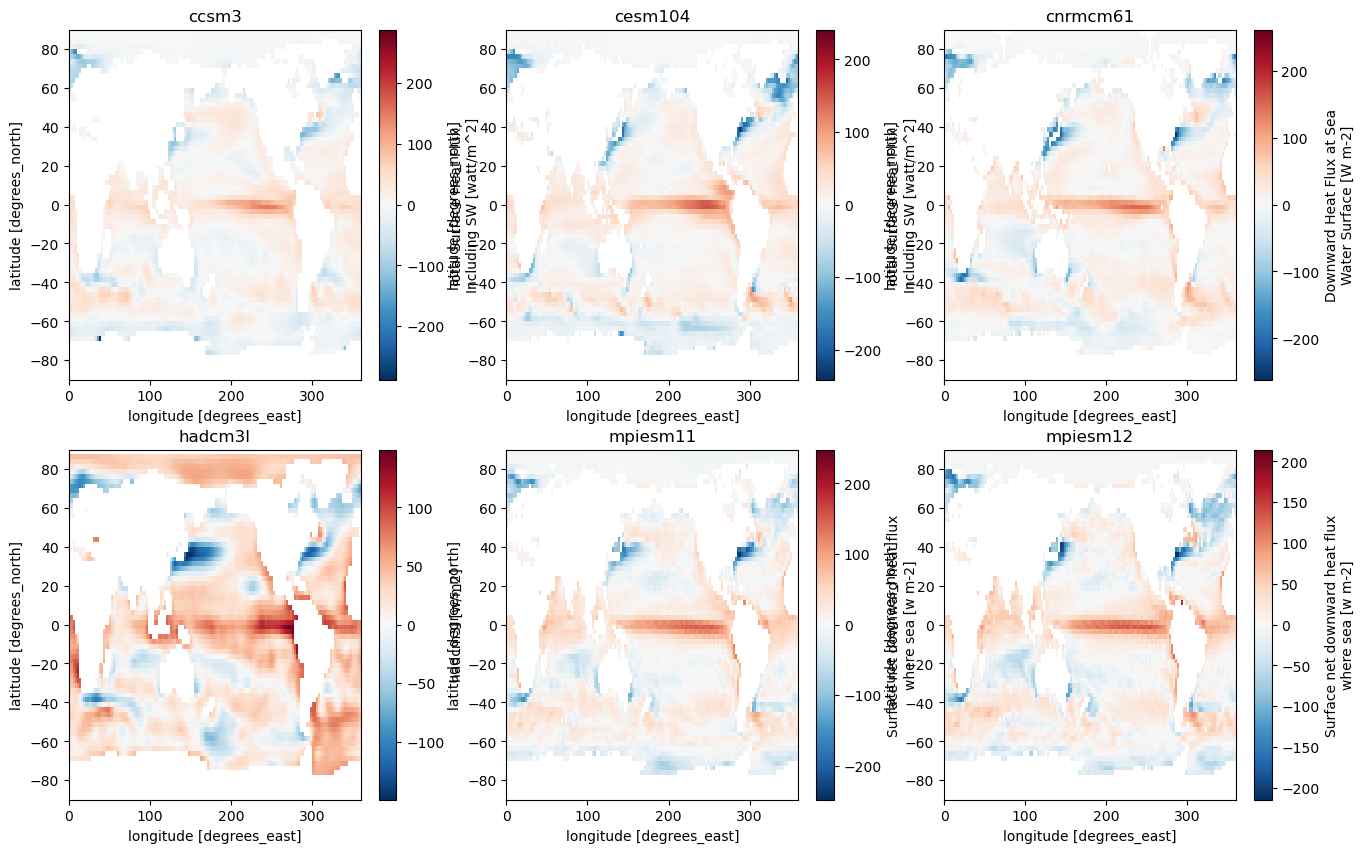

In [207]:
models = list(abrupt4x_ds.data_vars)
num_cols = 3
num_rows = int(np.ceil(len(models)/num_cols))

fig = plt.figure(figsize=(16,10))

for i,model in enumerate(models):
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    
    abrupt4x_ds[model].isel(time=0).plot(ax=ax)
    ax.set_title(model)
    
    ax.set_title(model)

In [208]:
constants.HEMISPHERE_LAT[experiment_params['hemisphere']]

(0, 90)

In [209]:
abrupt4x_mean,control_ds_mean = sn.calculate_global_value(abrupt4x_ds, control_ds, 
                                                          experiment_params["variable"],
                                                constants.HEMISPHERE_LAT[experiment_params['hemisphere']])

ccsm3, cesm104, cnrmcm61, hadcm3l, mpiesm11, mpiesm12, 

In [210]:
constants.MULTI_WINDOW_RUN_PARAMS

{'start_window': 10, 'end_window': 152, 'step_window': 1}

In [211]:
max_effective_length =  constants.LONGRUNMIP_LENGTH#sn.get_upper_lim(abrupt4x_mean, constants.MULTI_WINDOW_RUN_PARAMS['end_window'])
max_effective_length

848

In [212]:
%%time
stable_sn_ds, unstable_sn_ds = abrupt4x_mean.sn_ds.sn_multiwindow(
    control_ds_mean, parallel=True, **constants.MULTI_WINDOW_RUN_PARAMS)

- 
====ccsm3


Experiment
--------

range(10, 152)
13, 10, 16, 19, 22, 25, 28, 31, 37, 34, 46, 43, 52, 55, 40, 49, 20, 38, 11, 14, 17, 39, 47, 23, 44, 41, 35, 21, 56, 53, 32, 18, 12, 26, 29, 48, 50, 45, 15, 24, 58, 54, 42, 61, 59, 33, 57, 64, 67, 30, 70, 51, 73, 62, 76, 79, 82, 36, 85, 65, 27, 88, 71, 74, 60, 91, 68, 83, 94, 97, 80, 75, 100, 72, 89, 77, 86, 95, 63, 66, 103, 69, 84, 90, 106, 98, 109, 104, 112, 101, 78, 96, 92, 81, 99, 107, 102, 105, 110, 113, 87, 115, 118, 124, 121, 108, 127, 130, 133, 136, 139, 111, 142, 145, 125, 119, 134, 93, 122, 128, 114, 116, 148, 151, 137, 143, 120, 126, 131, 146, 123, 149, 135, 129, 140, 117, 144, 138, 132, 147, 141, 150, 
Control
------

range(10, 152)
16, 19, 22, 10, 13, 25, 31, 37, 40, 28, 34, 43, 52, 49, 46, 14, 17, 20, 55, 32, 23, 26, 29, 53, 11, 47, 38, 18, 41, 33, 44, 50, 21, 35, 15, 27, 24, 30, 56, 54, 48, 39, 12, 58, 42, 61, 64, 45, 51, 36, 67, 70, 73, 57, 76, 79, 82, 85, 59, 88, 91, 65, 94, 68, 97, 77, 62, 71, 86, 74, 100, 83, 103, 66,

In [213]:
number_models_present = sn.count_over_data_vars(abrupt4x_mean, list(unstable_sn_ds.data_vars), dim='model')

unstable_number_da = sn.number_finite(unstable_sn_ds)
stable_number_da = sn.number_finite(stable_sn_ds)

unstable_number_da

<xarray.DataArray (window: 142, time: 1192)>
array([[0, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       [0, 6, 6, ..., 0, 0, 0],
       ...,
       [6, 6, 6, ..., 0, 0, 0],
       [0, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0]])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1192-12-31 00:00:00
    depth    float64 0.0
  * window   (window) int64 10 11 12 13 14 15 16 ... 145 146 147 148 149 150 151

In [214]:
%%time
stable_point_ds = sn.get_dataset_stable_year_multi_window(unstable_sn_ds).rename({'variable': 'model'})
stable_point_ds

CPU times: user 1.1 s, sys: 72.8 ms, total: 1.18 s
Wall time: 1.2 s


<xarray.Dataset>
Dimensions:  (window: 142, model: 6)
Coordinates:
    depth    float64 0.0
  * window   (window) int64 10 11 12 13 14 15 16 ... 145 146 147 148 149 150 151
  * model    (model) <U8 'ccsm3' 'cesm104' 'cnrmcm61' ... 'mpiesm11' 'mpiesm12'
Data variables:
    time     (model, window) int64 3 3 3 2 3 3 3 ... 321 322 397 398 542 492 490

In [215]:
stable_point_ds = xr.where(stable_point_ds.time > max_effective_length, stable_point_ds, stable_point_ds.time)

# Plots

### Mean Temp Plots

In [216]:
hemisphere_title = string.capwords(experiment_params['hemisphere'].replace('_', ' '))
hemisphere_title

'Northern Hemisphere'

In [217]:
mask_title = f'({experiment_params["mask"]} only)' if experiment_params["mask"] else ''
mask_title

'(sea only)'

In [218]:
run_tag = f'{notebook_number}_{experiment_params["variable"]}' +\
        f'_{experiment_params["hemisphere"]}_mask_{experiment_params["mask"]}'
run_tag

'03_00_surf_northern_hemisphere_mask_sea'

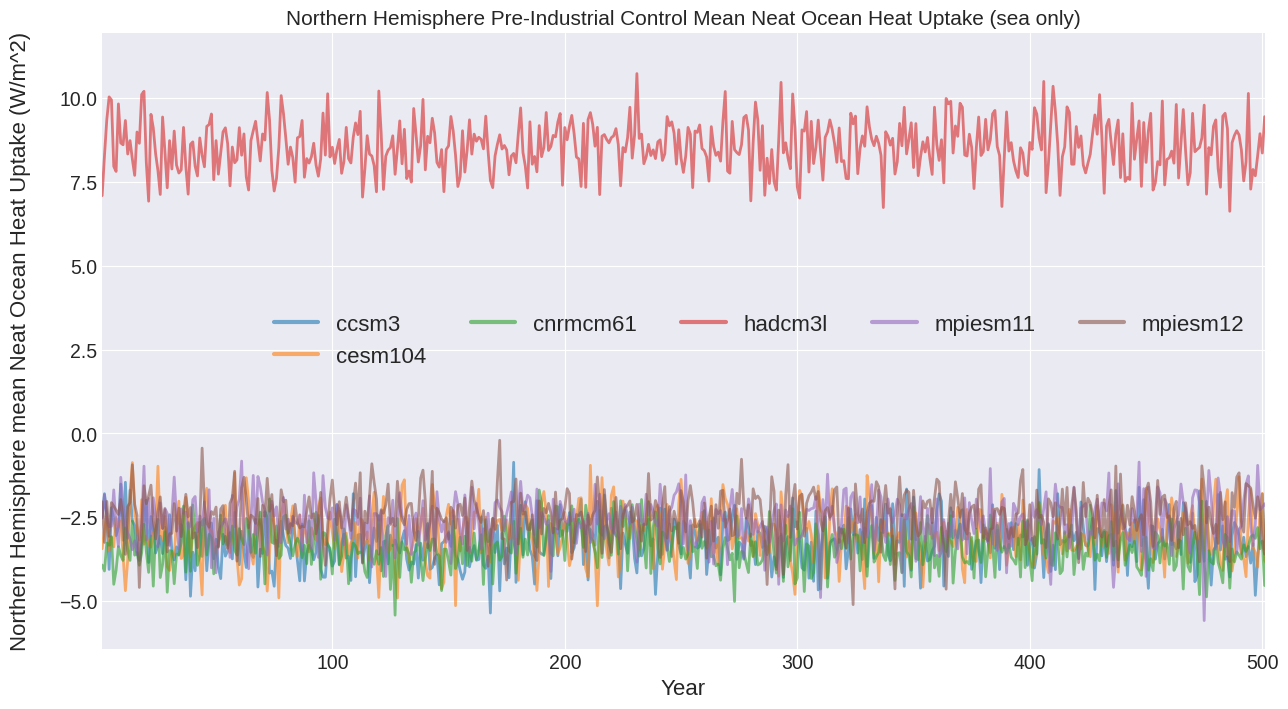

In [219]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

time = control_ds_mean['time'].values
years = [t.year for t in time]
for var in list(control_ds_mean.data_vars):

    plot_kwargs = dict(alpha = 0.6,linewidth = 2)
        
    ax.plot(years, control_ds_mean[var].values, label=var, **plot_kwargs) #  - 273.15
    
ax.set_ylabel(f'{hemisphere_title} mean {longname} ({units})', size=16, labelpad=20)
ax.set_xlabel('Year', size=16)
ax.set_xlim(years[0], years[500])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol = 5, fontsize=16)
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title(f'{hemisphere_title} Pre-Industrial Control Mean {longname} {mask_title}', fontsize=15);

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{run_tag}_mean_control.png'))

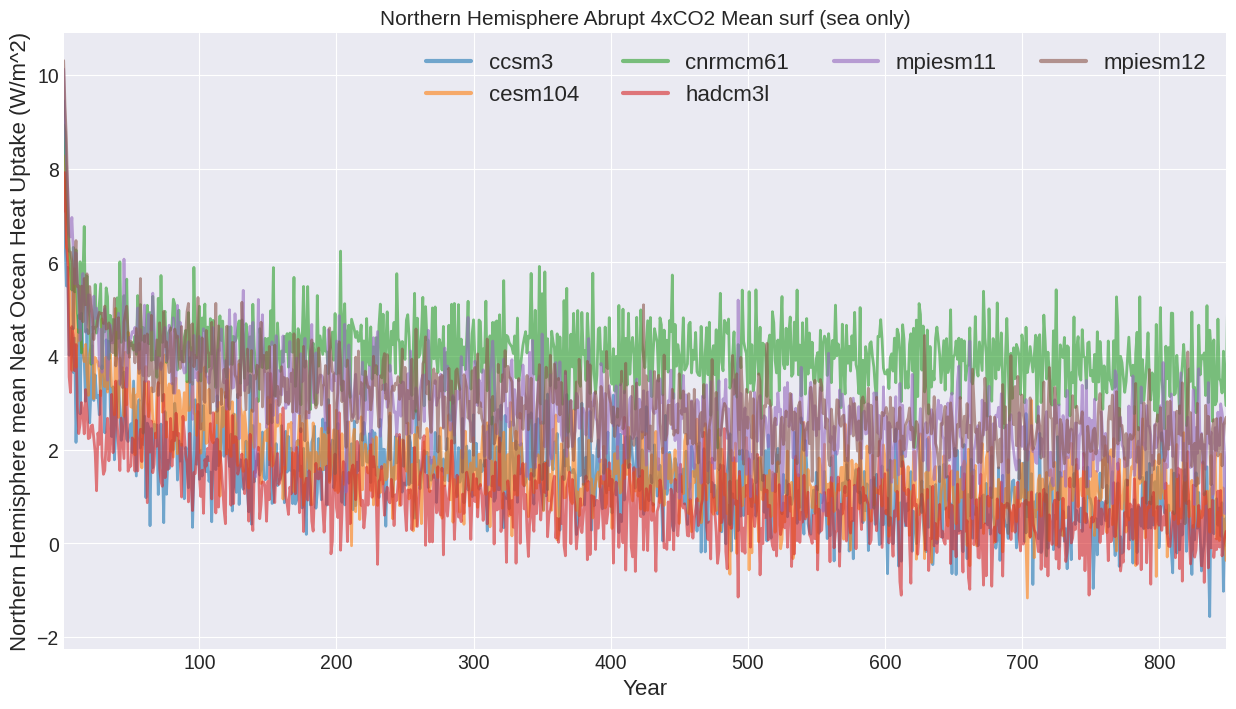

In [220]:
plt.style.use('seaborn-darkgrid')

data = abrupt4x_mean.where(abrupt4x_mean.time.dt.year < 13500, drop = True)

fig, ax = plt.subplots(figsize=(15,8))

for var in list(data.data_vars):
    
    # Removing nans from data
    da = data[var].dropna(dim='time')
    time = da.time.values
    years = [t.year for t in time]

    values = da.values
    
    line_kwargs = dict(alpha = 0.6,linewidth = 2)
    
    ax.plot(years, values, label=var, **line_kwargs)
    c = plt.gca().lines[-1].get_color()
#     ax.annotate(var, xy = (time[-1], values[-1]), color=c, zorder=1000, size=12)

ax.set_ylabel(f'{hemisphere_title} mean {longname} ({units})', size=16)
ax.set_xlabel('Year', size=16);
ax.set_title(f'{hemisphere_title} Abrupt 4xCO2 Mean {experiment_params["variable"]} {mask_title}', fontsize=15);

# ax.set_ylim([0,15]);|
ax.set_xlim(years[0], years[max_effective_length])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol=4, fontsize = 16);
[line.set_linewidth(3) for line in leg.get_lines()];
fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{run_tag}_mean_abrupt4x.png'))

### Signal to Noise

In [221]:
models = [model for model in list(constants.MODEL_PARAMS) if model in stable_point_ds.model.values]
models

['ccsm3', 'mpiesm12', 'cesm104', 'hadcm3l', 'mpiesm11', 'cnrmcm61']

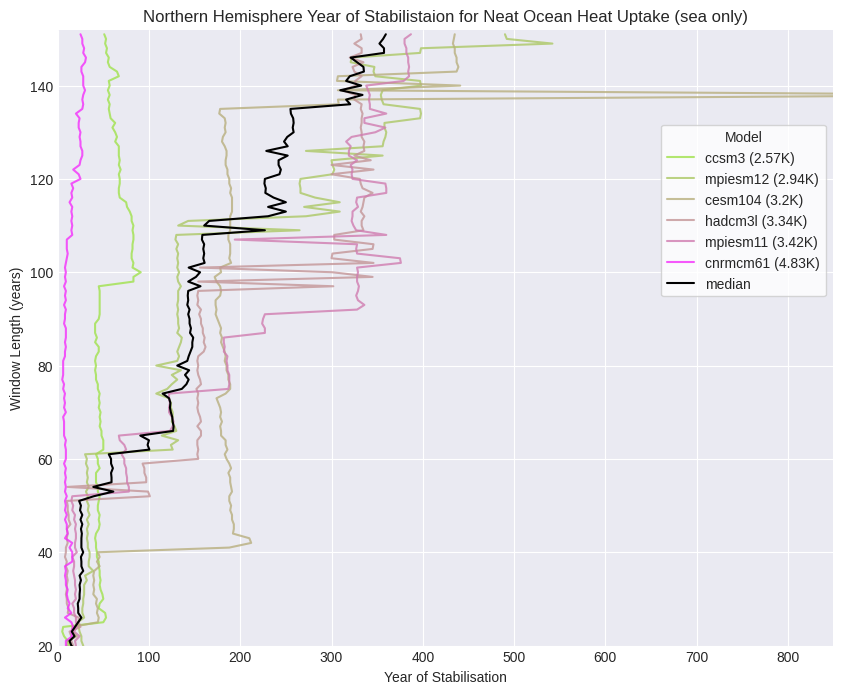

In [222]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111)

for model in models:
    color = constants.MODEL_PARAMS[model]['color']
    ECS = constants.MODEL_PARAMS[model]['ECS']
    label = f'{model} ({ECS}K)' 
    da = stable_point_ds.sel(model=model).time.plot(ax=ax,y='window', label=label, color=color, linewidth=1.5,
                                                   alpha=0.8)
    
stable_point_ds.median(dim='model').time.plot(ax=ax,y='window', label='median', color='k', linewidth=1.5) 

ax.set_xlim(0, max_effective_length + 1)
ax.set_ylim(20, constants.MULTI_WINDOW_RUN_PARAMS['end_window'])
leg = ax.legend(ncol=1, bbox_to_anchor=[1, 0.857], frameon=True, facecolor='white')
leg.set_title('Model')
leg.get_title().set_fontsize('10')
title = f'{hemisphere_title} Year of Stabilistaion for {longname} {mask_title}'
ax.set_title(title)
ax.set_xlabel('Year of Stabilisation')
ax.set_ylabel('Window Length (years)')


save_name = os.path.join(
    constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{run_tag}_all_models_stable_year.png')

fig.savefig(save_name, bbox_inches='tight', dpi=200)

ccsm3
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_surf_northern_hemisphere_mask_sea_ccsm3_signal_to_noise_multiwindow.png
mpiesm12
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_surf_northern_hemisphere_mask_sea_mpiesm12_signal_to_noise_multiwindow.png
cesm104
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_surf_northern_hemisphere_mask_sea_cesm104_signal_to_noise_multiwindow.png
hadcm3l
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_surf_northern_hemisphere_mask_sea_hadcm3l_signal_to_noise_multiwindow.png
mpiesm11
- No matching models found data_vars=['variable']
Saving /home/563/ab2313/gdata/images/PhD/top_level/03_00_surf_northern_hemisphere_mask_sea_mpiesm11_signal_to_noise_multiwindow.png
cnrmcm61
- No matching models found data_vars=['variabl

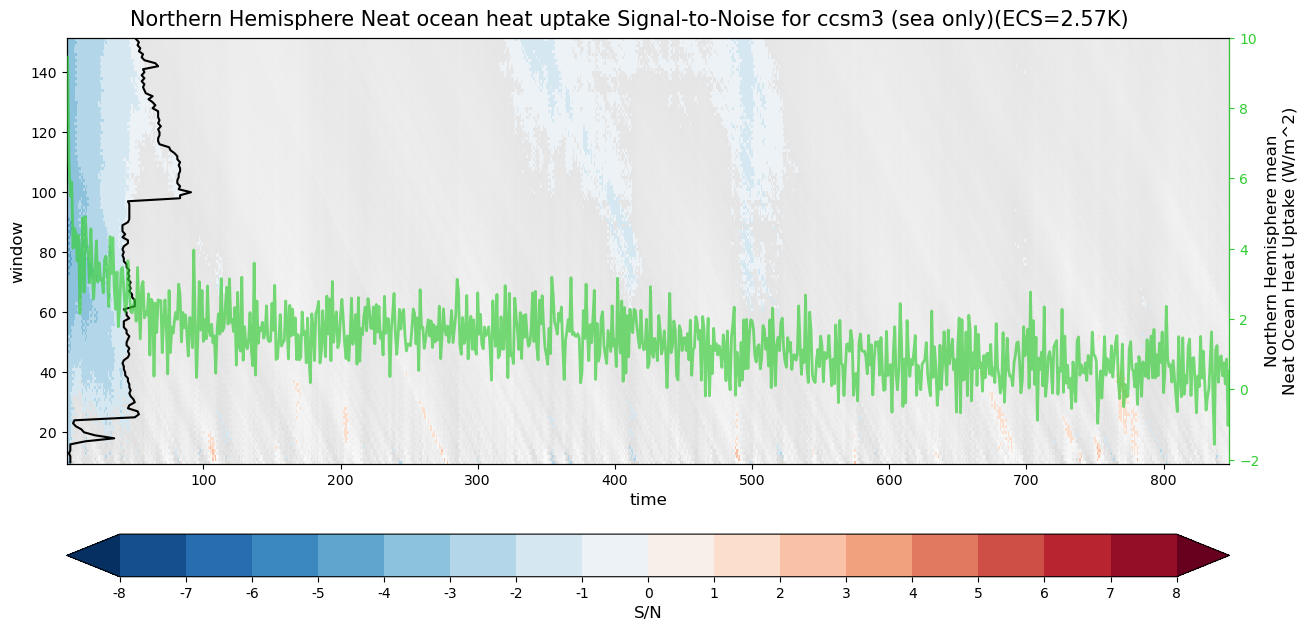

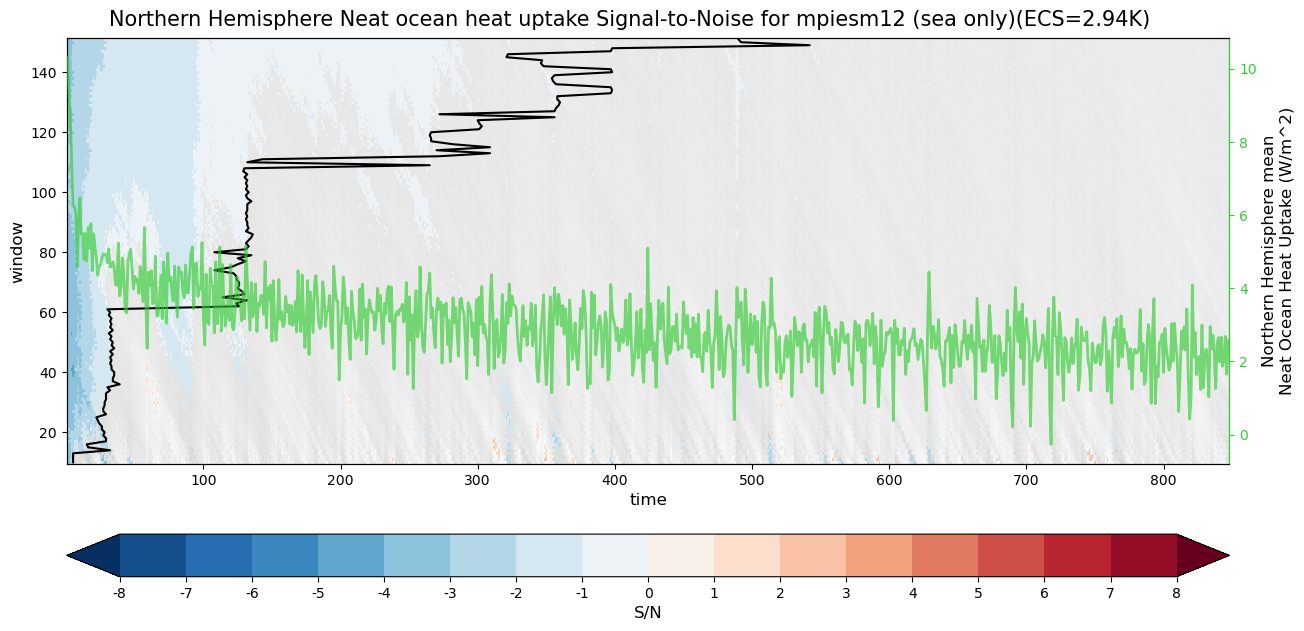

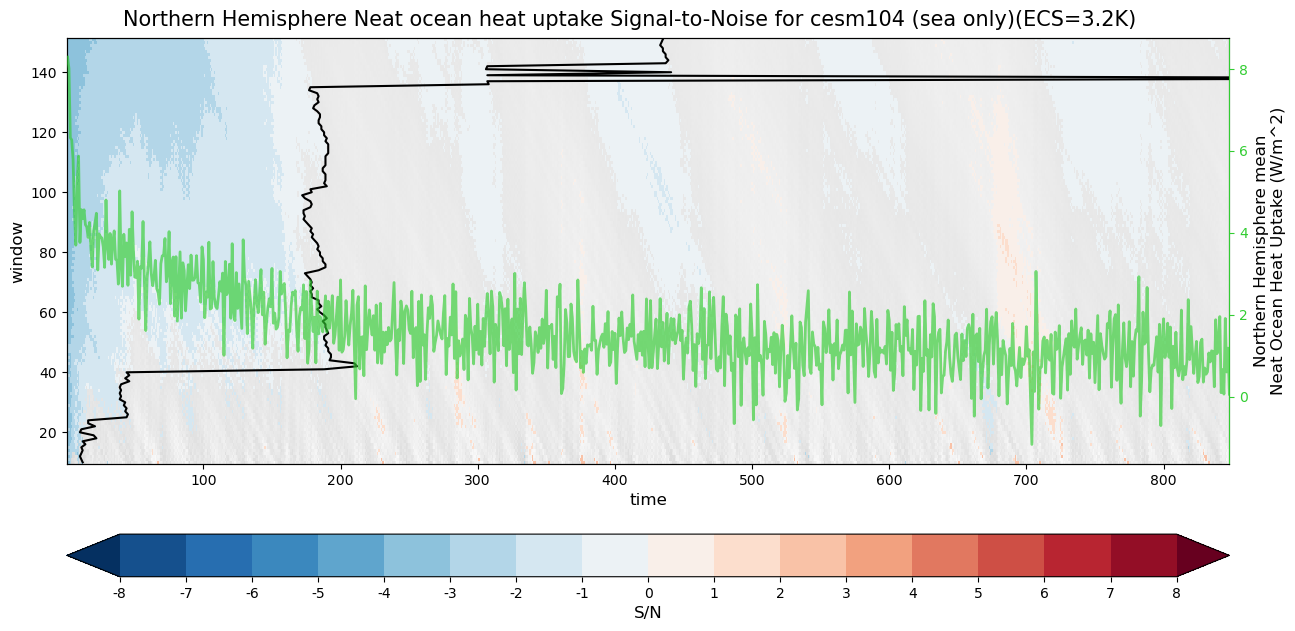

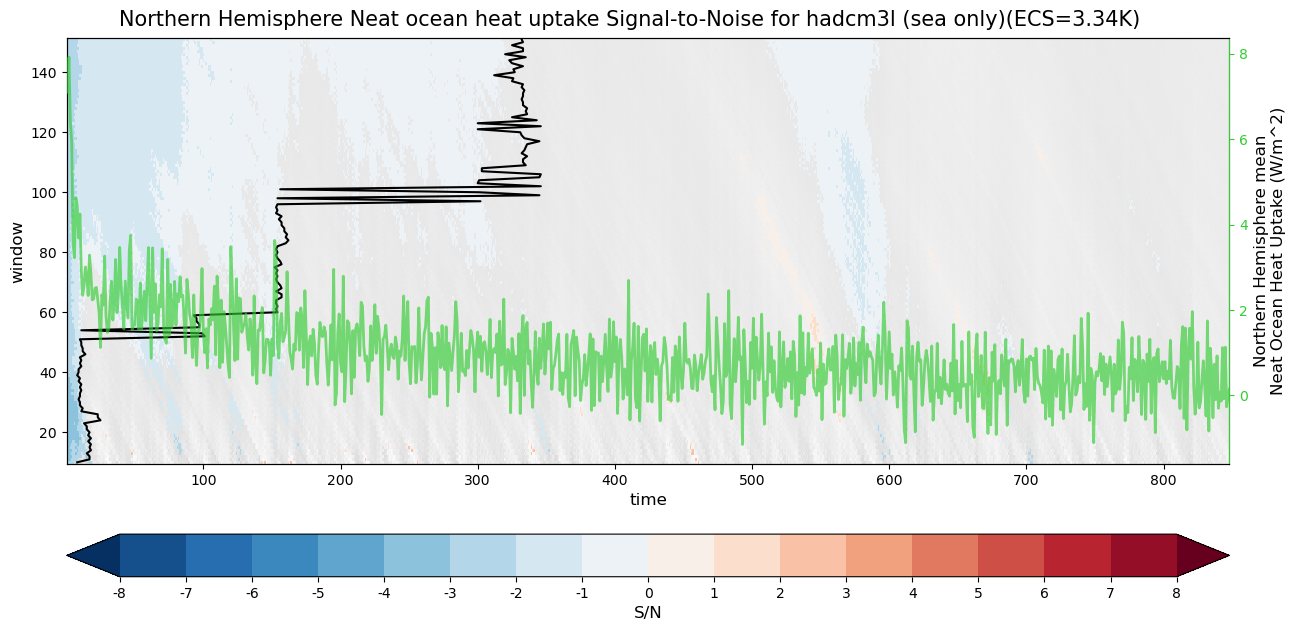

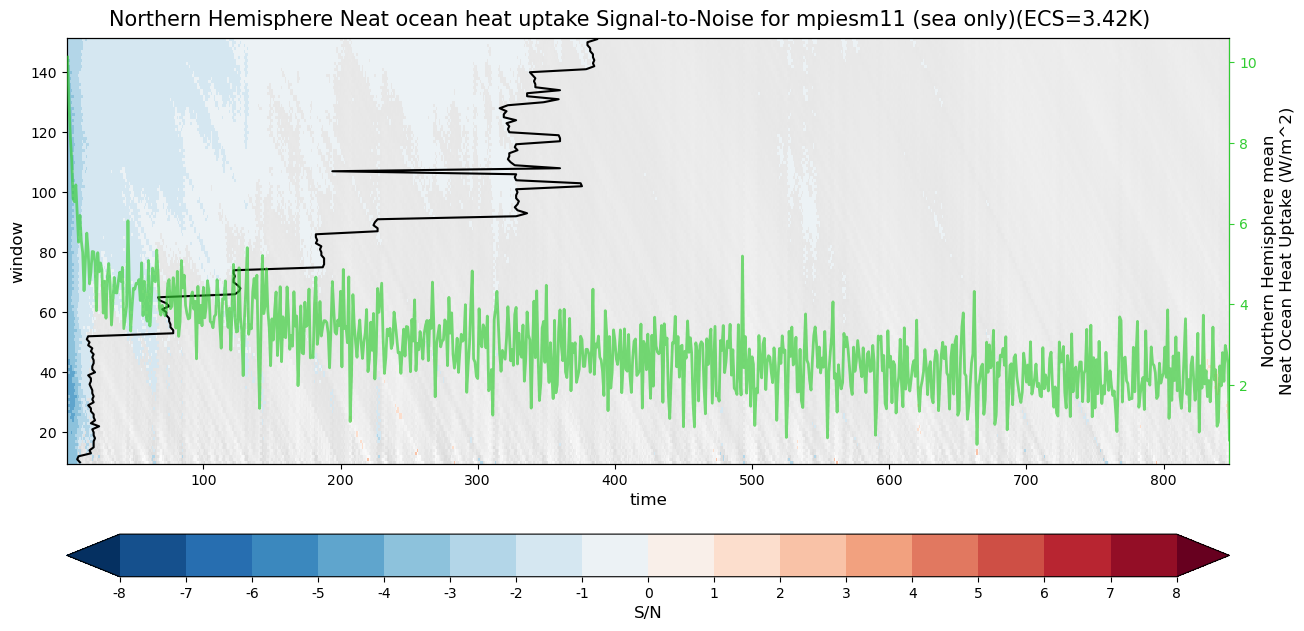

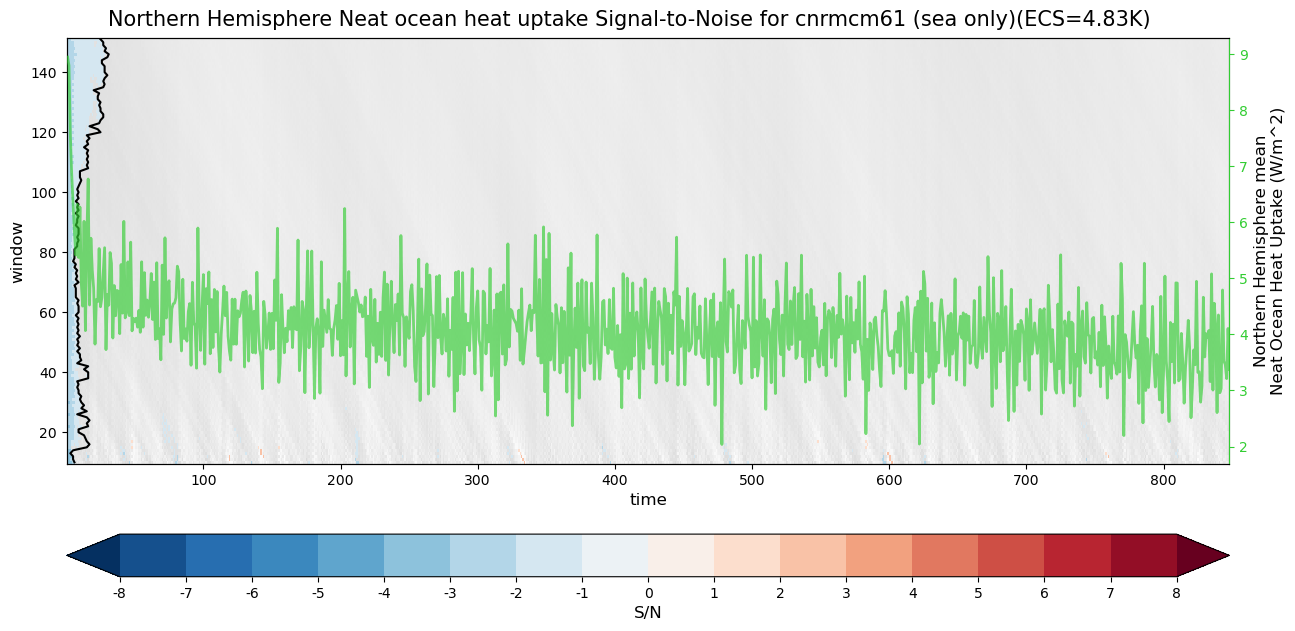

In [223]:
xupperlim = max_effective_length
reload(sn_plot)
mpl.rcParams.update(mpl.rcParamsDefault)

for model in list(models):
    print(model)
    ECS = constants.MODEL_PARAMS[model.lower()]['ECS']
    title = f'{hemisphere_title} {longname.capitalize()} Signal-to-Noise for {model} {mask_title}(ECS={ECS}K)'
    (fig, ax1, ax2, ax3, cbar) = sn_plot.sn_multi_window_in_time(unstable_sn_ds[model], 
                            stable_sn_ds[model], abrupt4x_mean[model].dropna(dim='time'),
                            title=title, step=1, xupperlim=xupperlim,
                            ax2_ylabel = f'{hemisphere_title} mean\n{longname} ({units})',
                                                                logginglevel='ERROR');

    stable_point_ds.sel(model=model).time.plot(y='window',  ax=ax1, color='k')
    ax1.set_title('')
    
    save_name = os.path.join(
        constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
        f'{run_tag}_{model}_signal_to_noise_multiwindow.png')
    
    print(f'Saving {save_name}')
    fig.savefig(save_name, dpi=400, bbox_inches='tight')

In [224]:
experiment_params["variable"] in ['sic', 'surf']

True

In [225]:
cmap = "Blues" if experiment_params["variable"] in ['sic', 'surf'] else 'Reds'
cmap

'Blues'

- {'ax2_ylabel': 'Global Mean\nNeat Ocean Heat Uptake (W/m^2)',
 'cbar_label': 'Number of Unstable Models',
 'cbar_ncols': 3,
 'cbar_ticks': array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 'cbar_xticklabels': array([0, 1, 2, 3, 4, 5, 6]),
 'cbartick_offset': 0.5,
 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7f5388e2ef70>,
 'extend': 'neither',
 'filter_max': True,
 'height': 15,
 'hieght': 15,
 'hspace': 0.3,
 'label_size': 12,
 'levels': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'line_alpha': 0.65,
 'line_color': 'limegreen',
 'step': 1,
 'title': 'Northern Hemisphere Fraction of Models Stable for Neat Ocean Heat '
          'Uptake (sea only)',
 'vmax': 7,
 'vmin': 0,
 'width': 12,
 'xlowerlim': None,
 'xupperlim': 848}
- locator: <matplotlib.ticker.FixedLocator object at 0x7f536f812c70>
- cbar x-tick labels = [0 1 2 3 4 5 6]
- data_vars=['ccsm3', 'cesm104', 'cnrmcm61', 'hadcm3l', 'mpiesm11', 'mpiesm12']
- 0 ccsm3, 
- 1 mpiesm12, 
- 2 cesm104, 
- 3 hadcm3l, 
- 4 mpiesm11, 
- 

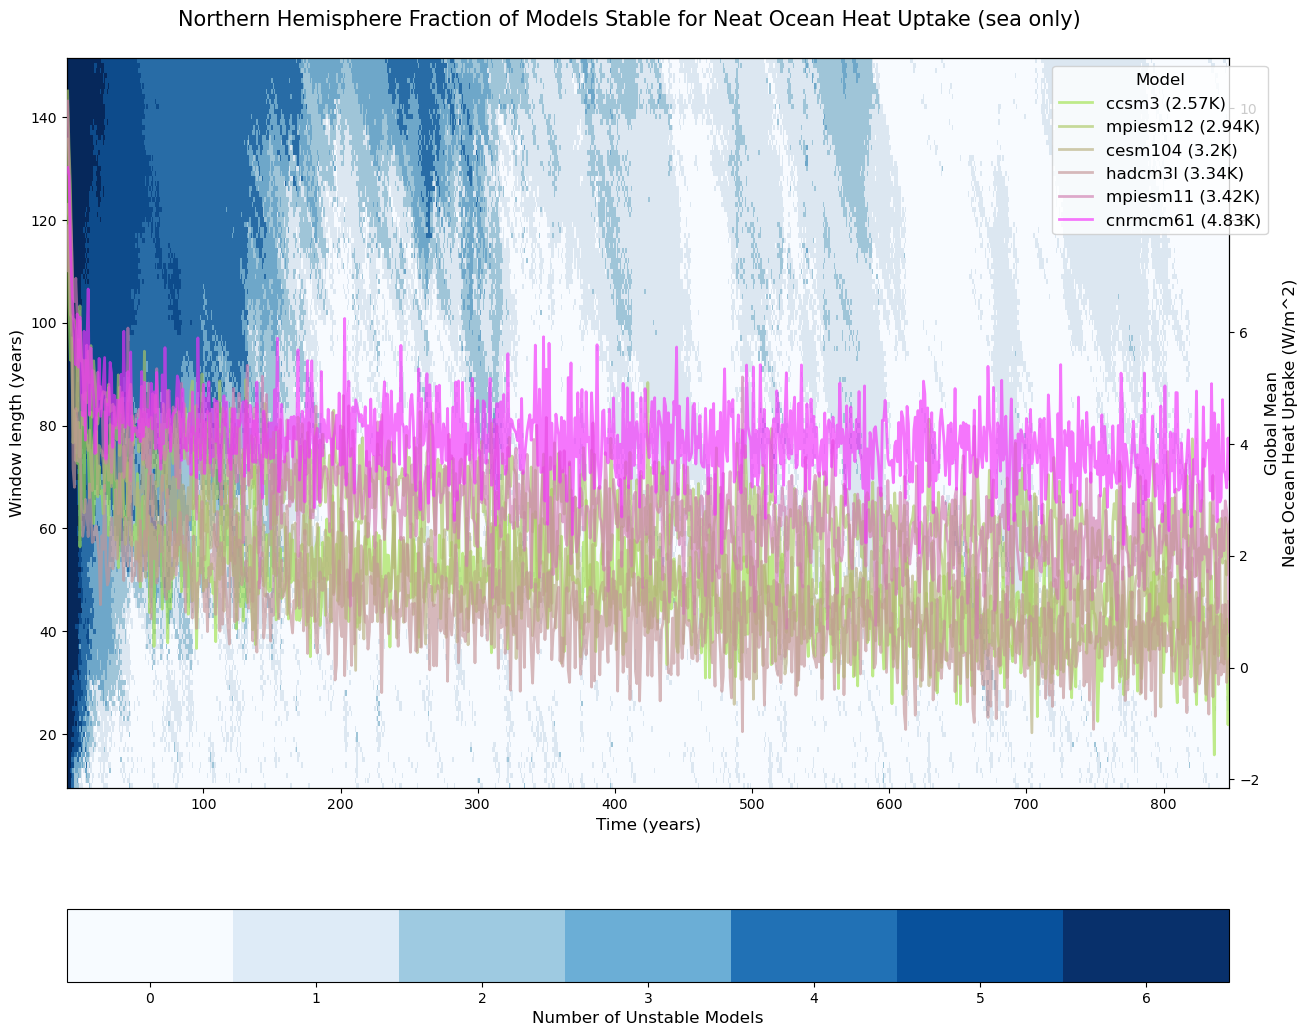

In [226]:
reload(sn_plot)
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax1, ax2, ax3,cbar = sn_plot.sn_multi_window_in_time(
    unstable_number_da, stable_number_da, abrupt4x_mean, 
    logginglevel='DEBUG', 
    hieght = 15, width = 12,
    vmin=0, vmax=len(models)+1, step=1, cbartick_offset = 0.5,
    cmap=cmap,
    extend='neither', xupperlim = max_effective_length,
    cbar_label= 'Number of Unstable Models', 
    ax2_ylabel = f'Global Mean\n{longname} ({units})',
    title = f'{hemisphere_title} Fraction of Models Stable for {longname} {mask_title}',
    cbar_ncols = 3, filter_max=True)


save_name = os.path.join(
        constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
        f'{run_tag}_all_models_signal_to_noise_multiwindow.png')
print(save_name)
fig.savefig(save_name , dpi=200, bbox_inches='tight')